In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import numpy as np
%matplotlib inline
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [11]:
import os,sys
os.chdir("/gdrive/My Drive/Colab Notebooks/PyTorch/hymenoptera_data")
path = "/gdrive/My Drive/Colab Notebooks/PyTorch/hymenoptera_data"

# Data loading with Augmentation, Normalization

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = path
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}
#dataloader를 사전식으로 저장해놓은거                                             
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



In [59]:
dataloaders['train'],dataloaders['val']

(<torch.utils.data.dataloader.DataLoader at 0x7fc19bcbffd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc19bcc0320>)

# Visualize Image : Image 몇 장 확인

In [43]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    means=[]
    stds=[]
    for c in range(3):
      mean = torch.mean(inp[:, c])
      means.append(mean)
      std = torch.std(inp[:, c])
      stds.append(std)
      inp[:, c] = (inp[:, c] - mean) / std
    
    inp = inp.numpy().transpose((1, 2, 0))
    #n_channels = batch.shape[1] #normalizing
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    stds=np.array(stds)
    means=np.array(means)
    
    inp = stds * inp + means
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




In [38]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

inputs.shape[1]

3

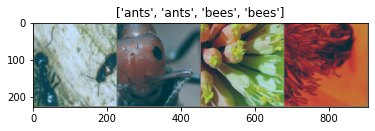

In [40]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

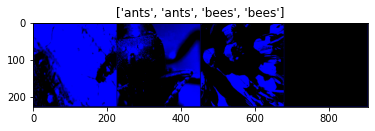

In [44]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [78]:
from torch.optim import lr_scheduler
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions
Generic function to display predictions for a few images

In [93]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]),color='white')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet 
Load a pretrained model and reset final fully connected layer.
초기값으로 pretrained 된 param 이용 -update 진행 , FC는 새로 설정

In [90]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [91]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6443 Acc: 0.6680
val Loss: 0.2735 Acc: 0.8889

Epoch 2/25
----------
train Loss: 0.6514 Acc: 0.7090
val Loss: 0.3405 Acc: 0.8758

Epoch 3/25
----------
train Loss: 1.1747 Acc: 0.6967
val Loss: 1.3094 Acc: 0.6797

Epoch 4/25
----------
train Loss: 0.6193 Acc: 0.8033
val Loss: 0.4582 Acc: 0.8301

Epoch 5/25
----------
train Loss: 0.5483 Acc: 0.7828
val Loss: 0.9041 Acc: 0.7059

Epoch 6/25
----------
train Loss: 0.8916 Acc: 0.7172
val Loss: 0.6986 Acc: 0.7712

Epoch 7/25
----------
train Loss: 0.3975 Acc: 0.8689
val Loss: 0.4204 Acc: 0.8562

Epoch 8/25
----------
train Loss: 0.5186 Acc: 0.8156
val Loss: 0.3347 Acc: 0.9020

Epoch 9/25
----------
train Loss: 0.4281 Acc: 0.8402
val Loss: 0.2830 Acc: 0.9020

Epoch 10/25
----------
train Loss: 0.3808 Acc: 0.8443
val Loss: 0.2902 Acc: 0.8758

Epoch 11/25
----------
train Loss: 0.3808 Acc: 0.8443
val Loss: 0.2817 Acc: 0.8889

Epoch 12/25
----------
train Loss: 0.3587 Acc: 0.8525
val Loss: 0.2882 Acc: 0.8824

E

In [81]:
type(model_ft)

torchvision.models.resnet.ResNet

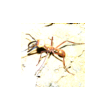

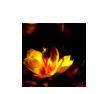

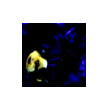

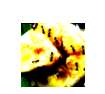

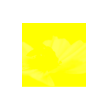

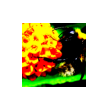

In [94]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor
이번에는 pretrained 된 parameter 그대로 사용, 여전히 FC는 새로

In [95]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # final

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [96]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.5592 Acc: 0.6680
val Loss: 0.2189 Acc: 0.9346

Epoch 2/25
----------
train Loss: 0.6074 Acc: 0.7254
val Loss: 0.1978 Acc: 0.9412

Epoch 3/25
----------
train Loss: 0.4657 Acc: 0.7664
val Loss: 0.1876 Acc: 0.9412

Epoch 4/25
----------
train Loss: 0.4703 Acc: 0.7910
val Loss: 0.1841 Acc: 0.9542

Epoch 5/25
----------
train Loss: 0.4088 Acc: 0.8402
val Loss: 0.1653 Acc: 0.9542

Epoch 6/25
----------
train Loss: 0.3821 Acc: 0.8361
val Loss: 0.1872 Acc: 0.9477

Epoch 7/25
----------
train Loss: 0.4150 Acc: 0.8156
val Loss: 0.2094 Acc: 0.9346

Epoch 8/25
----------
train Loss: 0.2952 Acc: 0.8648
val Loss: 0.1975 Acc: 0.9216

Epoch 9/25
----------
train Loss: 0.2244 Acc: 0.9139
val Loss: 0.1624 Acc: 0.9477

Epoch 10/25
----------
train Loss: 0.3181 Acc: 0.8648
val Loss: 0.1713 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.3548 Acc: 0.8320
val Loss: 0.2067 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.3497 Acc: 0.8484
val Loss: 0.1934 Acc: 0.9477

E

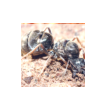

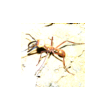

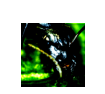

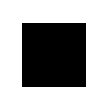

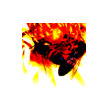

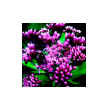

In [97]:
visualize_model(model_conv)

plt.ioff()
plt.show()